In [20]:
# On importe les librairies dont on aura besoin pour ce tp
import sys
import warnings
import collections
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from nltk import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from mosestokenizer import MosesDetokenizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from yellowbrick.text import FreqDistVisualizer
from sklearn.externals import joblib

# Pour ne pas avoir les warnings lors de la compilation
warnings.filterwarnings("ignore")

# Lieu où se trouve le fichier
if sys.platform == "windows":
    _FICHIER = 'QueryResults.csv'
    _DOSSIER = 'C:\\Users\\Toni\\Desktop\\pas_synchro\\p6\\'
    _DOSSIERTRAVAIL = 'C:\\Users\\Toni\\python\\python\\Projet_6\\images'

elif sys.platform == "linux":
    _FICHIER = 'stackoverflow_train_dataset.csv'
    _DOSSIER = '/home/toni/Bureau/'
    _DOSSIERTRAVAIL = '/home/toni/python/Projet_6/images/'

# Fonctions utiles

    Fonction qui permets l'exploration des données

In [21]:
def exploration(data):
    """
    Phase d'exploration des données
    """

    # Affichae du score des questions
    score_per_question = collections.Counter(data['Score'])
    scorewerid, noanswers = zip(*score_per_question.most_common())

    for number in [10, 25, 50]:
        plt.bar(scorewerid[:number], noanswers[:number], align='center', alpha=0.75)
        titre = 'Score des questions pour N=' + str(number)
        plt.ylabel('Nombre de questions')
        plt.xlabel('Score')
        plt.title(titre)
        plt.show()

    # Tags plus fréquents
    tagcount = comptage(list(data['Tags'])).most_common(10)
    print(tagcount)
    axe_x, axe_y = zip(*tagcount)

    plt.figure(figsize=(9, 8))
    titre = 'Ocurrence des tags'
    plt.title(titre)
    plt.ylabel("Nombre de questions concernées")
    for i in range(len(axe_y)):
        plt.bar(i, axe_y[i], align='center', alpha=0.75, label=axe_x[i])

    plt.legend(numpoints=1)
    plt.show()

    Analyse des données manquantes

In [22]:
def donnees_manquantes(data, nom):
    """
    Données manquantes
    """

    # Données manquantes
    missing_data = data.isnull().sum(axis=0).reset_index()
    missing_data.columns = ['column_name', 'missing_count']
    missing_data['filling_factor'] = (data.shape[0]-missing_data['missing_count'])/data.shape[0]*100
    print(missing_data.sort_values('filling_factor').reset_index(drop=True), "\n")

    # Transposition du dataframe de données pour l'analyse univariée
    data_transpose = data.describe().reset_index().transpose()
    print(data_transpose)

    Fonction de comptage pour les tags

In [23]:
def comptage(data):
    """
    Fonction qui va compter l'occurence de tous les mots
    """

    count = collections.Counter()

    stop_words = set(stopwords.words('english'))

    for sentence in data:
        sentence = word_tokenize(sentence.lower())
        for word in sentence:
            if (not word in stop_words) and word.isalpha():
                count[word] += 1

    return count

    Fonction de suppression des balises HTML et des parties de code

In [24]:
def suppr_html_code(fichier):
    """
    Fonction de suppression des balises HTML et des parties de code
    """

    # Suppression des balises HTML
    soupe = BeautifulSoup(fichier, "lxml")

    # Recherche des balises de 'code'
    liste = soupe.findAll('code')

    # Suppression des données qui sont entre les balises de code
    for balise in liste:
        balise.decompose()

    # Sortie formatée en texte
    return soupe.text

# Fonction principale

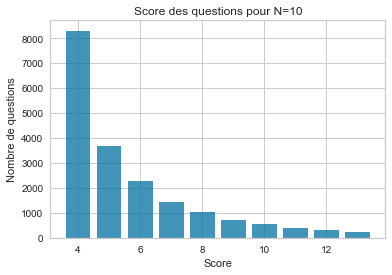

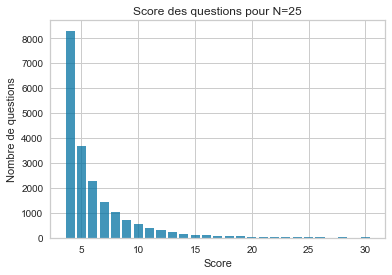

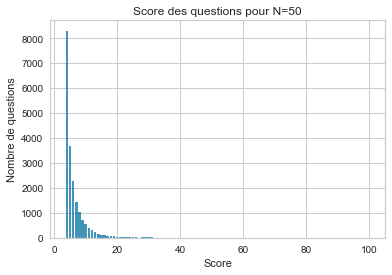

[('python', 2223), ('javascript', 2060), ('java', 1960), ('c', 1790), ('android', 1455), ('r', 904), ('php', 636), ('ios', 636), ('html', 619), ('angular', 615)]


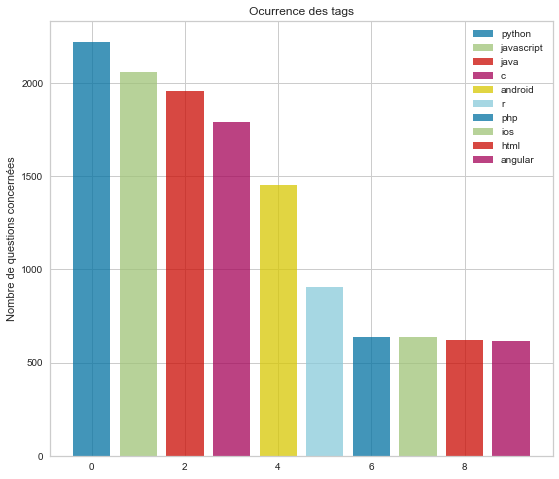

In [25]:
# Récupération du dataset
data = pd.read_csv(_DOSSIER + _FICHIER, error_bad_lines=False)

# Reduction de la taille à cause de limites techniques
data = data[0:20000]

# Appel de fonction pour l'exploration
exploration(data)

    Fusion des titres avec les body des données

In [26]:
data['Body'] = data['Title'] + data['Body']
data['Tags'] = data['Tags'].str.replace("<", "")
data['Tags'] = data['Tags'].str.replace(">", " ")

# Données manquantes
donnees_manquantes(data, "missing_data_1")

    column_name  missing_count  filling_factor
0         Title              0           100.0
1          Tags              0           100.0
2          Body              0           100.0
3  CreationDate              0           100.0
4         Score              0           100.0 

           0        1        2    3    4    5    6     7
index  count     mean      std  min  25%  50%  75%   max
Score  20000  6.81625  16.9182    4    4    5    7  2200


    Création de la liste des tags d'origines, uniques

In [27]:
liste_tags = []

for i in range(0, len(data)):
    words = word_tokenize(data.loc[i, 'Tags'])

    for j in words:
        if j.isalpha() and (j not in liste_tags):
            liste_tags.append(j)

for i in liste_tags[:10]:
    print(i)

python
pandas
javascript
java
recursion
c
macros
scala
int
php


    Création de la liste des mots contenus dans les body

In [28]:
# Suppression des balises html et des parties de code
data['Body'] = [suppr_html_code(x) for x in data['Body']]

# Comptage du nombre d'occurence
cpt = comptage(data['Body'])
print(cpt)

Counter({'using': 12253, 'code': 11599, 'like': 10923, 'use': 8045, 'get': 7708, 'error': 7577, 'would': 7372, 'want': 6484, 'one': 6481, 'way': 6389, 'function': 5994, 'following': 5989, 'file': 5719, 'data': 5532, 'example': 4806, 'problem': 4589, 'also': 4358, 'tried': 4315, 'trying': 4216, 'app': 4165, 'work': 4160, 'need': 4103, 'type': 3995, 'class': 3898, 'know': 3786, 'could': 3662, 'see': 3637, 'time': 3577, 'method': 3544, 'value': 3514, 'however': 3508, 'question': 3464, 'two': 3423, 'works': 3376, 'new': 3375, 'first': 3318, 'user': 3312, 'something': 3246, 'list': 3237, 'run': 3190, 'make': 3092, 'set': 3056, 'working': 2996, 'find': 2989, 'different': 2923, 'object': 2880, 'used': 2756, 'create': 2731, 'project': 2691, 'version': 2687, 'possible': 2672, 'without': 2663, 'application': 2661, 'output': 2611, 'issue': 2601, 'seems': 2588, 'array': 2557, 'help': 2506, 'case': 2441, 'server': 2413, 'values': 2400, 'call': 2371, 'add': 2339, 'still': 2293, 'https': 2293, 'solut